In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import os
import tqdm
import tqdm.contrib
import matplotlib.pyplot as plt
import gc

In [3]:
songs_df = pd.read_json("../NCSDownload/songs_linked.json")
songs_df = songs_df[~songs_df["genre"].isin(["N/A", ""])].dropna()
songs_df["genre"] = songs_df["genre"].apply(lambda x: [s.strip() for s in x.split(",")])
songs_df.reset_index(inplace=True, drop=True) 

mood_onehot = pd.get_dummies(songs_df["moods"].explode()).groupby(level=0).sum()
genre_onehot = pd.get_dummies(songs_df["genre"].explode()).groupby(level=0).sum()
target_df = pd.concat([mood_onehot, genre_onehot], axis=1)
print(target_df.shape, mood_onehot.shape, genre_onehot.shape)
print(sorted(list(mood_onehot.columns)))
print(sorted(list(genre_onehot.columns)))

X = []
y = []
samples = 512
step = 512
for index, row in tqdm.tqdm(songs_df.iterrows(), total=len(songs_df)):
    basename = os.path.basename(row["file"])
    file_only = os.path.splitext(basename)[0]
    path = "specgrams/" + file_only + ".png"
    if os.path.isfile(path):
        img = read_image(path, ImageReadMode.GRAY)
        if img.shape[2] < samples:
            continue
        img = img.unfold(2, samples, step).moveaxis(2, 0)
        X.append(img)
        target = torch.tensor(genre_onehot.iloc[index].to_numpy())
        y.append(target.repeat(img.shape[0], 1))

(1294, 51) (1294, 34) (1294, 17)
['Angry', 'Bass', 'Bass House', 'Chill', 'Dark', 'Dreamy', 'Drum & Bass', 'EDM', 'Electronic', 'Energetic', 'Epic', 'Euphoric', 'Fear', 'Funny', 'Future House', 'Glamorous', 'Gloomy', 'Happy', 'Hopeful', 'Indie', 'Laid Back', 'Melodic Dubstep', 'Mysterious', 'Peaceful', 'Quirky', 'Relaxing', 'Restless', 'Romantic', 'Sad', 'Scary', 'Sexy', 'Suspense', 'Trap', 'Weird']
['Bass', 'Bass House', 'Chill', 'Drum & Bass', 'Drumstep', 'Dubstep', 'EDM', 'Electronic', 'Future Bass', 'Future House', 'Glitch Hop', 'Hardstyle', 'House', 'Indie', 'Melodic Dubstep', 'Phonk', 'Trap']


100%|██████████| 1294/1294 [00:26<00:00, 48.88it/s]


[0.17507886 0.170347   0.16798107 0.11829653 0.11277603 0.06466877
 0.05205047 0.0362776  0.03312303 0.02996845 0.02365931 0.02208202
 0.01656151 0.00709779 0.00630915 0.00315457 0.00236593]
[0.17507886 0.34542587 0.51340694 0.63170347 0.7444795  0.80914826
 0.86119874 0.89747634 0.93059937 0.96056782 0.98422713 1.00630915
 1.02287066 1.02996845 1.0362776  1.03943218 1.04179811]


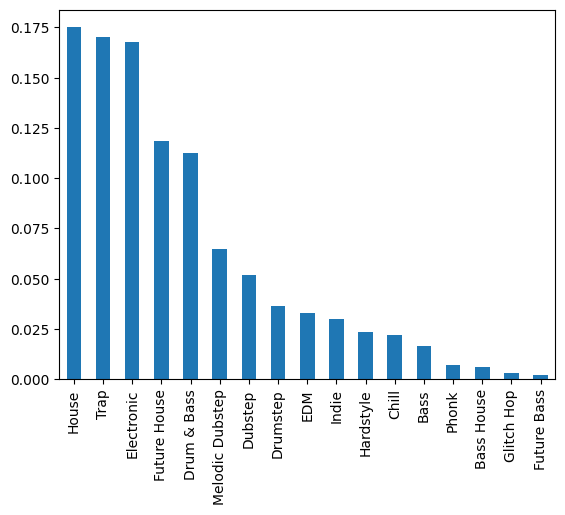

In [19]:
genre_onehot.sum().apply(lambda x: x / len(X)).sort_values(ascending=False).plot.bar()
p = genre_onehot.sum().apply(lambda x: x / len(X)).sort_values(ascending=False).values
print(p)
print(np.cumsum(p))

torch.Size([20363, 1, 128, 512]) torch.Size([20363, 17])


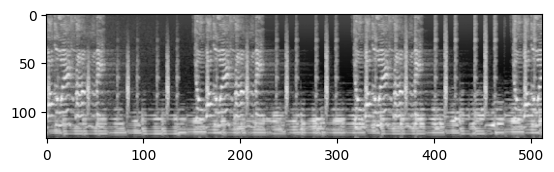

In [4]:
y = torch.concat(y).float()
X = (torch.concat(X).float() / 255.0) * 2 - 1
gc.collect()
Xmean = torch.mean(X, 0)
Xstd = torch.std(X, 0)
np.save("Xmean.npy", Xmean.numpy())
np.save("Xstd.npy", Xstd.numpy())
X = (X - torch.mean(X, 0)) / torch.std(X, 0)
plt.imshow(X[1].squeeze().numpy(), cmap="gray")

# y = torch.tensor(target_df.to_numpy()).float()[:, 34:]
print(X.shape, y.shape)

In [3]:
device = torch.device("mps")
# X, y = X.to(device), y.to(device)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=496)
Xtrain, Xtest, ytrain, ytest = Xtrain.to(device), Xtest.to(device), ytrain.to(device), ytest.to(device)
# class_weights = 1 - (torch.bincount(ytrain.int()) / len(ytrain))

NameError: name 'X' is not defined

In [13]:
del X, y
gc.collect()

3057

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, 17)
        self.dropout = nn.Dropout(0.5)
        self.dropout2d = nn.Dropout2d(0.2)
    
    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        # x = self.dropout2d(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.softmax(x, dim=1)
        # x = F.sigmoid(x)
        # out1, out2 = torch.split(x, 34, dim=1)
        # out1 = torch.softmax(out1, dim=1)
        # out2 = torch.softmax(out2, dim=1)
        # x = torch.cat((out1, out2), dim=1)
        return x
    
model = Net().to(device)

In [5]:
class PlainNet(nn.Module):
    def __init__(self):
        super(PlainNet, self).__init__()
        self.fc1 = nn.Linear(128*512, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 17)
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.softmax(self.fc5(x), dim=1)

model = PlainNet().to(device)

In [6]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCELoss() # nn.CrossEntropyLoss(weight=class_weights)

total_params = 0
for p in model.parameters():
    total_params += p.numel()
print(f"Total parameters: {total_params:_}")

Total parameters: 67_801_105


In [15]:
for epoch in range(100):
    gc.collect()
    train_whole = False
    batchXs = torch.split(X if train_whole else Xtrain, 64)
    batchYs = torch.split(y if train_whole else ytrain, 64)
    running_loss = 0
    correct = 0
    # correct3 = 0
    model.train()
    for batchX, batchY in tqdm.contrib.tzip(batchXs, batchYs):
        optim.zero_grad()
        pred = model(batchX)
        guesses = torch.argmax(pred, dim=1)
        correct += torch.gather(batchY, 1, guesses.reshape(-1, 1)).sum().item()
        # correct3 += (torch.topk(pred, 3, dim=1).indices == batchY.u snsqueeze(1)).sum().item()
        loss = criterion(pred, batchY)
        loss.backward()
        
        running_loss += loss.item()
        optim.step()
    acc = correct / len(Xtrain)
    with torch.no_grad():
        model.eval()
        batchXs = torch.split(Xtest, 64)
        batchYs = torch.split(ytest, 64)
        correct = 0
        for batchX, batchY in tqdm.contrib.tzip(batchXs, batchYs):
            pred = model(batchX)
            guesses = torch.argmax(pred, dim=1)
            correct += torch.gather(batchY, 1, guesses.reshape(-1, 1)).sum().item()
        val_acc = correct / len(ytest)
        # val_acc = (torch.argmax(pred, dim=1) == ytest).sum().item() / len(ytest)
        # val_acc3 = (torch.topk(pred, 3, dim=1).indices == ytest.unsqueeze(1)).sum().item() / len(ytest)
        print(f"Epoch {epoch} - loss {running_loss} - acc {acc} - val acc {val_acc}")


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 0 - loss 56.64199601113796 - acc 0.1416206261510129 - val acc 0.21949423029707832


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1 - loss 55.91202527284622 - acc 0.16292203806015962 - val acc 0.2668794500368279


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2 - loss 54.95845802128315 - acc 0.18747697974217312 - val acc 0.3088632457647925


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3 - loss 54.2017854899168 - acc 0.20049109883364027 - val acc 0.3135281119567886


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4 - loss 53.85583460330963 - acc 0.21227747084100676 - val acc 0.3582126196906457


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5 - loss 53.11338713765144 - acc 0.22750153468385512 - val acc 0.366805794254849


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6 - loss 52.69486531615257 - acc 0.23100061387354204 - val acc 0.38571077829609623


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7 - loss 51.88270452618599 - acc 0.25156537753222835 - val acc 0.4051068008838694


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8 - loss 51.12602350115776 - acc 0.2591160220994475 - val acc 0.392094279400933


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9 - loss 50.922717243433 - acc 0.2642111724984653 - val acc 0.40363368524429166


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10 - loss 50.25618897378445 - acc 0.2710865561694291 - val acc 0.4144365332678615


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11 - loss 49.563999474048615 - acc 0.2796193984039288 - val acc 0.42032899582617234


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12 - loss 49.1159682571888 - acc 0.2903621853898097 - val acc 0.432113920942794


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13 - loss 48.417237028479576 - acc 0.2907305095150399 - val acc 0.41836484164006876


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14 - loss 47.89205867052078 - acc 0.2998158379373849 - val acc 0.4276945740240609


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15 - loss 47.356896966695786 - acc 0.3114180478821363 - val acc 0.4353056714952124


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16 - loss 46.61538200080395 - acc 0.31663597298956414 - val acc 0.45298305917014486


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17 - loss 46.11786298453808 - acc 0.3252302025782689 - val acc 0.4416891726000491


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18 - loss 45.680015206336975 - acc 0.3289134438305709 - val acc 0.4598575988215075


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19 - loss 45.32199354469776 - acc 0.3292817679558011 - val acc 0.45101890498404124


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20 - loss 44.649808034300804 - acc 0.34174340085942295 - val acc 0.4588755217284557


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21 - loss 44.37138678878546 - acc 0.34088397790055247 - val acc 0.45200098207709305


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22 - loss 43.76357203722 - acc 0.3506445672191529 - val acc 0.45617480972256325


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23 - loss 43.276786774396896 - acc 0.35991405770411294 - val acc 0.4647679842867665


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24 - loss 43.0707428753376 - acc 0.3572744014732965 - val acc 0.46550454210655534


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25 - loss 42.55130171775818 - acc 0.3605893186003683 - val acc 0.46354038792045177


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26 - loss 42.10689849406481 - acc 0.3670349907918969 - val acc 0.4605941566412963


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27 - loss 42.092859007418156 - acc 0.36734192756292205 - val acc 0.4596120795482445


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28 - loss 41.705554991960526 - acc 0.3729281767955801 - val acc 0.4704149275718144


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29 - loss 41.43915654718876 - acc 0.37734806629834255 - val acc 0.4684507733857108


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30 - loss 41.07065389305353 - acc 0.3789441375076734 - val acc 0.4642769457402406


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 31 - loss 40.84668019413948 - acc 0.3807243707796194 - val acc 0.47704394794991406


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 32 - loss 40.63071532547474 - acc 0.38391651319828113 - val acc 0.4790081021360177


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 33 - loss 40.076739355921745 - acc 0.39318600368324125 - val acc 0.4699238890252885


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 34 - loss 39.69409842789173 - acc 0.39772866789441375 - val acc 0.46722317701939603


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 35 - loss 39.27527789026499 - acc 0.4027010435850215 - val acc 0.4765529094033882


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 36 - loss 39.55593868345022 - acc 0.4002455494168201 - val acc 0.47507979376381043


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 37 - loss 38.965825751423836 - acc 0.4066298342541437 - val acc 0.47164252393812917


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 38 - loss 38.89613089710474 - acc 0.4097605893186004 - val acc 0.472379081757918


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 39 - loss 38.34378822892904 - acc 0.41596071209330876 - val acc 0.4804812177755954


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 40 - loss 38.5520358979702 - acc 0.41240024554941684 - val acc 0.48023569850233244


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 41 - loss 37.45504993200302 - acc 0.42793124616329037 - val acc 0.4652590228332924


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 42 - loss 37.86083113402128 - acc 0.41823204419889504 - val acc 0.4780260250429659


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 43 - loss 37.63284731656313 - acc 0.4219766728054021 - val acc 0.4701694082985514


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 44 - loss 37.74353811889887 - acc 0.4197667280540209 - val acc 0.4799901792290695


  0%|          | 0/255 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.fc1.register_forward_hook(get_activation('fc1'))
model.eval()
with torch.no_grad():
    preds = model(X)
    act = activation['fc1'].squeeze().cpu().numpy()
    np.save("song_vectors.npy", act)
    np.save("song_vectors_labels.npy",  target_df.to_numpy().astype(np.float32)[:, 34:])


In [16]:
if True:
    torch.save(model.state_dict(), 'model.pth')
else:
    model.load_state_dict(torch.load('model.pth'))